Machine learning for modern astronomy
====
Now that we've touched on the basic principles of ML and coded/understood at least some of it ourselves, we can now safely use ML frameworks while understanding what's going on beneath the layers of abstraction. ML frameworks provide convenient APIs, well-tested routines, and well-optimised code for building machine learning models -- the minutiae of how we write the low-level code is taken care of. This allows us to focus on getting the harder part of machine learning right -- building models robustly, characterising performance, and model architecture choices.

For this tutorial I'll introduce `keras`, a high-level API for `tensorflow`, one of the most popular machine learning frameworks. In this tutorial we will cover:
- Dataset preparation and pre-processing
- Building and training your model from scratch in `keras`
- Tracking and validating the training process
- Evaluating your model's performance
- Next steps.

__Note:__ This notebook can be intense computationally, so if you need to retrain your model, please restart the Jupyter kernel. This is necessary to avoid crashing sometimes.

In [156]:
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# helpful aliases to write shorter code
tfk = tf.keras
tfkl = tf.keras.layers

Dataset download
----
For this task we'll do some galaxy classification using the [Galaxy10 SDSS](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html) dataset. This is a dataset of around 22,000 galaxy images extracted from the Sloan Digital Sky Survey, with labels from the [Galaxy Zoo]() citizen science project. Each galaxy has a 3-channel, 69x69 image, and an associated label. These labels are:
\[Insert labels here\]

This download is around 200MB so may take a while - the code below will download this to the `data/` directory in this project. Please ensure you have enough space before downloading, and we may setup a local mirror of this download to avoid saturating the UToronto webservers during the workshop!

In [2]:
!wget --random-wait http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5 -P ../data

--2022-07-19 15:27:48--  http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
Resolving astro.utoronto.ca (astro.utoronto.ca)... 128.100.89.2
Connecting to astro.utoronto.ca (astro.utoronto.ca)|128.100.89.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 210234548 (200M) [text/plain]
Saving to: ‘../data/Galaxy10.h5.2’

Galaxy10.h5.2       100%[===================>] 200.50M  3.16MB/s    in 1m 57s  

utime(../data/Galaxy10.h5.2): No such file or directory
2022-07-19 15:29:45 (1.72 MB/s) - ‘../data/Galaxy10.h5.2’ saved [210234548/210234548]



In [2]:
# Load data into memory
with h5py.File("../data/Galaxy10.h5", "r") as data:
    images = np.array(data["images"])
    labels = np.array(data["ans"])

class_label_map = {
    "0": "Disk, Face-on, No Spiral",
    "1": "Smooth, Completely round",
    "2": "Smooth, in-between round",
    "3": "Smooth, Cigar shaped",
    "4": "Disk, Edge-on, Rounded Bulge",
    "5": "Disk, Edge-on, Boxy Bulge",
    "6": "Disk, Edge-on, No Bulge",
    "7": "Disk, Face-on, Tight Spiral",
    "8": "Disk, Face-on, Medium Spiral",
    "9": "Disk, Face-on, Loose Spiral",
}

Visualising the input data
-----
Something crucial to the ML process that is often overlooked is looking at your data. This can help give an intuition for the classification/regression problem and quickly allows you to spot outliers/other weirdnesses in your data. Below let's plot a few examples per class.

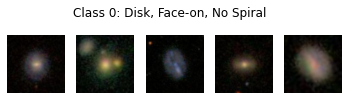

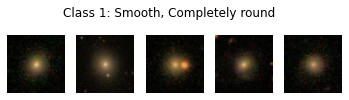

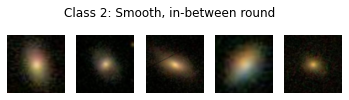

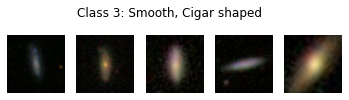

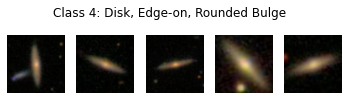

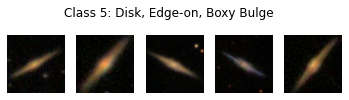

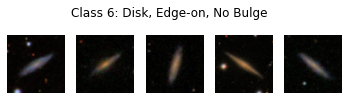

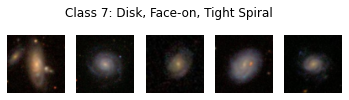

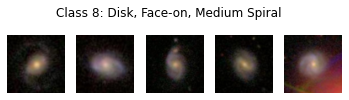

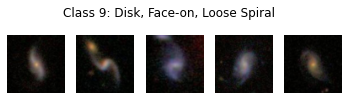

In [3]:
n_galaxies_to_show = 5
for cl in np.unique(labels):
    fig, ax = plt.subplots(1, n_galaxies_to_show)
    mask = np.argwhere(cl == labels)[:n_galaxies_to_show, 0]

    plt.suptitle(f"Class {cl}: {class_label_map[str(cl)]}", y=0.7)
    for a, idx in zip(ax, mask):
        a.imshow(images[idx])
        a.axis("off")

    plt.show()

In [4]:
class_label, count = np.unique(labels, return_counts=True)

for _cl, _ct in zip(class_label, count):
    print(class_label_map[str(_cl)].rjust(30), _ct)

      Disk, Face-on, No Spiral 3461
      Smooth, Completely round 6997
      Smooth, in-between round 6292
          Smooth, Cigar shaped 349
  Disk, Edge-on, Rounded Bulge 1534
     Disk, Edge-on, Boxy Bulge 17
       Disk, Edge-on, No Bulge 589
   Disk, Face-on, Tight Spiral 1121
  Disk, Face-on, Medium Spiral 906
   Disk, Face-on, Loose Spiral 519


Generating our own labels
----
This is a complex classification issue, with 10 potential labels. For now (we'll come back to this later as a challenge!) let's simplify this into a binary classification problem by reducing to simpler labels.
As a simple one to start with, let's just classify disks vs smooth galaxies. Maybe you can edit the below to choose a different split? (i.e. edge-on vs face-on)

In [177]:
labels_binarised = np.array([
    1 if "disk" in class_label_map[str(l)].lower() else 0 for l in labels
])
classes = ["disky", "non-disky"]

Dataset normalisation
----
For numerical stability, we need to make sure all data are scaled to a common range of values, and ensure this is close to 1. Although these cutouts are already scaled to 255, let's map them to -1, 1 to be sure.
Experiment with this! _What happens if we don't do this?_


In [6]:
normpoint = images.max() / 2
images = (images - normpoint) / normpoint

Train, validation, and test sets
----
A crucial part of robustly training and testing machine learning models is the use of multiple datasets.

In [7]:
# Pick your own seed!
random_seed = 42

# 80% of images for training on, 10% as test, 10% as validation
images_train, images_test, labels_train, labels_test = train_test_split(
    images, labels_binarised, test_size=0.2, random_state=42
)
images_test, images_val, labels_test, labels_val = train_test_split(
    images_test, labels_test, test_size=0.5, random_state=42
)

In [8]:
for data, name in zip(
    [images_train, images_val, images_test], ["train", "val", "test"]
):
    print(f"{name.ljust(7)}: {len(data)}")

train  : 17428
val    : 2179
test   : 2178


Building our model
---
Now let's dive straight into building our first model with `keras`. Let's build a basic deep convolutional neural network following the [VGG architecture](https://www.robots.ox.ac.uk/~vgg/publications/2015/Simonyan15/) of Simonyan and Zisserman. Of course, our task is very simple compared to what is utilised in the computer science literature, so I've aggressively downsized the model.

Feel free to play around with the parameters in the model.

In [9]:
model = tfk.Sequential(
    [
        tfkl.Conv2D(4, (3, 3), activation="relu", name="conv1", input_shape=images.shape[1:]),
        tfkl.Conv2D(4, (3, 3), activation="relu", name="conv2"),
        tfkl.MaxPooling2D(pool_size=(4, 4), padding='valid'),
        tfkl.Conv2D(8, (3, 3), activation="relu", name="conv3"),
        tfkl.Conv2D(8, (3, 3), activation="relu", name="conv4"),
        tfkl.MaxPooling2D((4, 4), padding='valid'),
        tfkl.Flatten(),
        tfkl.Dense(64, activation='relu', name='fc_1'),
        tfkl.Dense(1, activation='sigmoid', name='output')

    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 67, 67, 4)         112       
                                                                 
 conv2 (Conv2D)              (None, 65, 65, 4)         148       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 4)        0         
 )                                                               
                                                                 
 conv3 (Conv2D)              (None, 14, 14, 8)         296       
                                                                 
 conv4 (Conv2D)              (None, 12, 12, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 8)          0         
 2D)                                                    

2022-07-19 16:37:54.534244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-19 16:37:54.534321: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-19 16:37:54.534372: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ragnarok): /proc/driver/nvidia/version does not exist
2022-07-19 16:37:54.535409: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Remaining ingredients for our model
---
We need:
- An _optimiser_: to update our model weights in response to the training data
- A _loss function_: to define which steps in weight space improve the performance of our model.
- (Optionally, but we'll need them eventually): _metrics_, to give human-readable indications of performance.

By defining these ahead of time, we can _compile_ and _train_ our model, and `tensorflow` can handily compile all of these together into an optimised 'train step'.

In [10]:
# optimiser: let's use Adam with `learning_rate` = 3e-4. Why not try a different one from https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
optim = tfk.optimizers.Adam(learning_rate=3e-4)

# loss: binary classification problem, so binary cross-entropy is the way to go. See s1_linearmodelstoml for an introduction to this.
loss = tfk.losses.BinaryCrossentropy()

# metrics: as humans the Accuracy is probably our first thought! But there's a full range of metrics available at https://www.tensorflow.org/api_docs/python/tf/keras/metrics.
# why not try swapping in/adding Precision, Recall, KLDivergence etc.
metrics = [tfk.metrics.BinaryAccuracy(), tfk.metrics.AUC()]

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [11]:
history = model.fit(x=images_train, y=labels_train, batch_size=32, verbose=1, validation_data=(images_val, labels_val), shuffle=True, epochs=15)

Epoch 1/15
545/545 [==============================] - 17s 27ms/step - loss: 0.5958 - binary_accuracy: 0.6761 - auc: 0.7042 - val_loss: 0.5285 - val_binary_accuracy: 0.7563 - val_auc: 0.7907
Epoch 2/15
545/545 [==============================] - 12s 23ms/step - loss: 0.4872 - binary_accuracy: 0.7772 - auc: 0.8337 - val_loss: 0.4678 - val_binary_accuracy: 0.7962 - val_auc: 0.8453
Epoch 3/15
545/545 [==============================] - 11s 21ms/step - loss: 0.4405 - binary_accuracy: 0.8113 - auc: 0.8671 - val_loss: 0.4344 - val_binary_accuracy: 0.8114 - val_auc: 0.8708
Epoch 4/15
545/545 [==============================] - 17s 32ms/step - loss: 0.4136 - binary_accuracy: 0.8232 - auc: 0.8836 - val_loss: 0.4108 - val_binary_accuracy: 0.8274 - val_auc: 0.8846
Epoch 5/15
545/545 [==============================] - 14s 25ms/step - loss: 0.3958 - binary_accuracy: 0.8320 - auc: 0.8946 - val_loss: 0.3930 - val_binary_accuracy: 0.8320 - val_auc: 0.8960
Epoch 6/15
545/545 [==============================

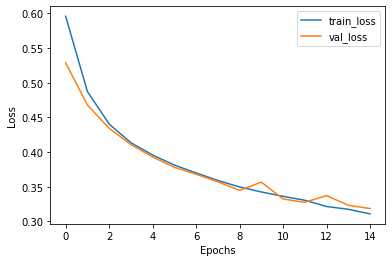

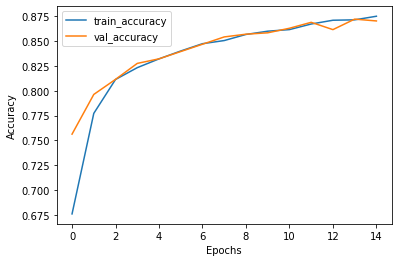

In [16]:
metrics = history.history

plt.plot(metrics['loss'], label='train_loss')
plt.plot(metrics['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(metrics['binary_accuracy'], label='train_accuracy')
plt.plot(metrics['val_binary_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

But how did we do on our test set?
----
From above, our validation loss/metrics seem to track the training metrics very well. But we should verify this with the held-out test set, just in case something in the training process is overinforming the model.
Let's also plot some common machine learning metrics to understand how our model performs in greater details. Below:
- We compute the metrics as above for a _decision boundary_ of 0.5. If a sample scores above the decision boundary it is classified as the True (i.e. disk) class, and vice versa below.
- We plot the ROC (Receiver Operating Characteristic) curve for a range of thresholds. By tuning the _decision boundary_ we can prioritise different things from our model.

In [118]:
result = model.evaluate(images_test, labels_test)
# get raw probability predictions.
labels_pred = model.predict(images_test, verbose=False)[:, 0]

for name, val in zip(model.metrics_names, result):
    print(f"{name}: {val:.3f}")

69/69 [==============================] - 1s 10ms/step - loss: 0.3273 - binary_accuracy: 0.8669 - auc: 0.9311
loss: 0.327
binary_accuracy: 0.867
auc: 0.931


Receiver Operating Characteristic curve (ROC curve)
---

ROC-AUC score: a common metric in binary classification. By integrating the area under the curve, we obtain the (average) probability that a given positive example is ranked higher than a negative example.

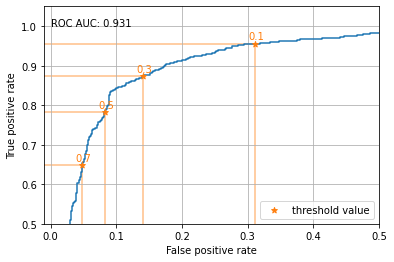

In [119]:
fpr, tpr, thresh = roc_curve(labels_test, labels_pred, drop_intermediate=True)
fpr = fpr[::-1]
tpr = tpr[::-1]
thresh = thresh[::-1]
plt.plot(fpr, tpr)

thresholds_desired = np.arange(0.1, 0.8, 0.2)
fprs_plot = np.interp(thresholds_desired, thresh, fpr)
tprs_plot = np.interp(thresholds_desired, thresh, tpr)
plt.scatter(fprs_plot, tprs_plot, c='C1', marker='*', zorder=20, label='threshold value')

for fp, tp, _thr in zip(fprs_plot, tprs_plot, thresholds_desired):
    plt.text(fp-0.01, tp+0.01, f"{_thr:.1f}", c='C1')
    plt.plot([-1000, fp, fp], [tp, tp, 0], c='C1', alpha=0.5, zorder=-1)

roc_auc = roc_auc_score(labels_test, labels_pred)
plt.text(0, 1, f"ROC AUC: {roc_auc:.3f}")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.xlim(-0.01, 0.5)
plt.ylim(0.5, )
plt.grid()
plt.legend(loc='lower right')
plt.show()

Confusion matrix
----
Another typical plot from the ML literature, but very informative. We're effectively plotting a slice of the above plot.
At what threshold do we do equally well at identifying disky and non-disky galaxies?

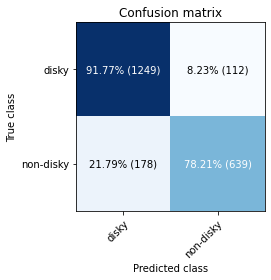

In [190]:
decision_threshold = 0.5

labels_pred_thresholded = labels_pred > decision_threshold

cm_raw = confusion_matrix(y_true=labels_test, y_pred=labels_pred_thresholded)
cm_norm = 100 * cm_raw / cm_raw.sum(axis=1, keepdims=True)

fig, ax = plt.subplots()
ax.imshow(cm_raw, cmap='Blues', interpolation=None)
ax.set(xticks=np.arange(cm_norm.shape[1]),
       yticks=np.arange(cm_norm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       title='Confusion matrix',
       ylabel='True class',
       xlabel='Predicted class',
       ylim=(1.5, -0.5),
       )
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, '{:.2f}% ({:d})'.format(cm_norm[i, j], cm_raw[i, j]),
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else "black",
                size=10)

plt.tight_layout()
plt.show()

Which examples was our model most uncertain about?
----
Heuristic idea: ones where the score is furthest from 0/1 -> i.e. 0.5

Formalise with probability theory into _entropy_:
$$ H = -\sum_{i=1}^{N} p_i \log_2{(p_i)}$$
where $i$ defines the classes in the data.

For our binary classification:
$$ H = -p \log_2{(p) - (1-p) \log_2{(1 - p)}$$

Implement the binary entropy below, and apply it to the test labels. To check it's working correctly:
$$
H(p=0) = 0 \\
H(p=1) = 0 \\
H(p=0.5) = 1 \\
$$

Text(0, 0.5, 'Entropy (nats)')

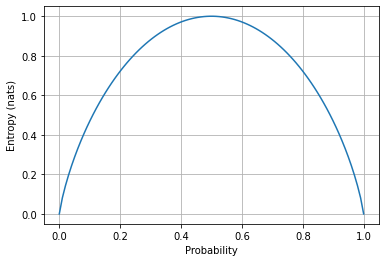

In [120]:
def binary_entropy(proba, eps=np.finfo(float).eps):
    """
    Compute binary entropy

    Parameters
    ----------
    proba : Union[float, int, np.ndarray]
        Probability
    eps : float
        Machine precision to compute result to: avoids NaN at domain edges.
    """
    p_clip = np.clip(proba, eps, 1-eps)
    h = -p_clip * np.log2(p_clip) - (1-p_clip)*np.log2(1-p_clip)
    return h

p = np.linspace(0, 1, 100)
h_p = binary_entropy(p)

plt.plot(p, h_p)
plt.grid()
plt.xlabel("Probability")
plt.ylabel("Entropy (nats)")

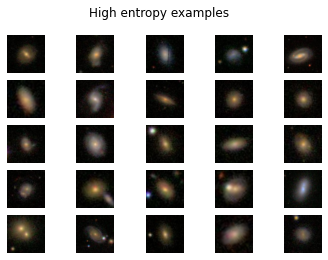

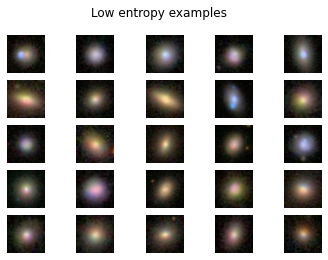

In [154]:
h_test_labels = binary_entropy(labels_pred)

idxs_ordered_entropy = np.argsort(h_test_labels)[::-1]

n_examples_per_axis = (5, 5)
n_high_entropy_examples = np.product(n_examples_per_axis)

fig, axes = plt.subplots(*n_examples_per_axis)
for ax, idx in zip(axes.ravel(), idxs_ordered_entropy[:n_high_entropy_examples]):
    img_reconstructed = (images_test[idx] * normpoint + normpoint).astype(int)
    ax.imshow(img_reconstructed, vmin=0, vmax=255)
    ax.axis("off")
fig.suptitle("High entropy examples")
plt.show()

idxs_ordered_entropy = np.argsort(h_test_labels)

n_examples_per_axis = (5, 5)
n_high_entropy_examples = np.product(n_examples_per_axis)

fig, axes = plt.subplots(*n_examples_per_axis)
for ax, idx in zip(axes.ravel(), idxs_ordered_entropy[:n_high_entropy_examples]):
    img_reconstructed = (images_test[idx] * normpoint + normpoint).astype(int)
    ax.imshow(img_reconstructed, vmin=0, vmax=255)
    ax.axis("off")
fig.suptitle("Low entropy examples")
plt.show()

Does this align with what you expected for this?
----
- We can (maybe) see that the high entropy examples have features of both disk/non-disk galaxies.